In [1]:
import tensorflow as tf
import pickle
import numpy as np
import timeit
import load_cifar_template as lc
from tensorflow.contrib.layers import flatten
import matplotlib.pyplot as plt
import time

from tqdm import tqdm
import scipy.io as spio
import pickle
import os
import cv2
import timeit
from skimage.transform import rescale, resize, downscale_local_mean

In [2]:
#fetch the data

def fetch_data(directory, label): 
    item_list = []
    step = 0
    for file in tqdm(os.listdir(directory)):
        full_img_str = directory + "/" + file
        #print(full_img_str)

        mat = spio.loadmat(full_img_str, squeeze_me=True)
        data = np.abs(mat["data_store"])
        smaller_data = data[25:225]
        
        #image_resized = resize(smaller_data, (100, 320, 4),
                       #anti_aliasing=True)
        
        sub_list = []
        for i in range(8):
            chunk = smaller_data[:,32*i:32*i+32]
            sub_list.append(chunk)
        
        #
        #print(data.shape)
        #print(data)
        ###append the img and label to the list###
        #sub_list = [image_resized, label]
        #print(sub_list)
        item_list.append([sub_list, label])
        
    return item_list
    
bike1 = fetch_data("Desktop/ee596prepro/2019_04_09_bms1000/data", [1, 0, 0])
bike2 = fetch_data("Desktop/ee596prepro/2019_04_09_bms1001/data", [1, 0, 0])
bike3 = fetch_data("Desktop/ee596prepro/2019_04_09_bms1002/data", [1, 0, 0])
bike4 = fetch_data("Desktop/ee596prepro/2019_04_30_bm1s005/data", [1, 0, 0])
bike5 = fetch_data("Desktop/ee596prepro/2019_04_30_bm1s006/data", [1, 0, 0])

car1 = fetch_data("Desktop/ee596prepro/2019_04_09_cms1000/data", [0, 1, 0])
car2 = fetch_data("Desktop/ee596prepro/2019_04_09_cms1001/data", [0, 1, 0])
car3 = fetch_data("Desktop/ee596prepro/2019_04_09_cms1002/data", [0, 1, 0])
car4 = fetch_data("Desktop/ee596prepro/2019_04_30_cm1s000/data", [0, 1, 0])
car5 = fetch_data("Desktop/ee596prepro/2019_05_09_cm1s004/data", [0, 1, 0])
car6 = fetch_data("Desktop/ee596prepro/2019_05_09_cs1m001/data", [0, 1, 0])

ped1 = fetch_data("Desktop/ee596prepro/2019_04_09_pms1000/data", [0, 0, 1])
ped2 = fetch_data("Desktop/ee596prepro/2019_04_09_pms1001/data", [0, 0, 1])
ped3 = fetch_data("Desktop/ee596prepro/2019_04_09_pms2000/data", [0, 0, 1])
ped4 = fetch_data("Desktop/ee596prepro/2019_04_09_pms2000/data", [0, 0, 1])
ped5 = fetch_data("Desktop/ee596prepro/2019_04_09_pms2000/data", [0, 0, 1])



#directory = "Desktop/ee596prepro/2019_04_09_bms1000/data"

100%|███████████████████████████████████████████████████████████████████████████████| 347/347 [00:01<00:00, 232.80it/s]


In [3]:
def mini_batch(features,labels,mini_batch_size):
    """
    Args:
        features: features for one batch
        labels: labels for one batch
        mini_batch_size: the mini-batch size you want to use.
    Hint: Use "yield" to generate mini-batch features and labels
    """
    #split the data into batches
    amount_of_data = len(features)
    number_of_bunches = amount_of_data/mini_batch_size
    
    bunches_features = []
    bunches_labels = []
    
    #loop over breaking the data into batches
    for i in range(int(number_of_bunches)):
        current_range = i * mini_batch_size
        f_b = features[current_range:current_range+mini_batch_size]
        l_b = labels[current_range:current_range+mini_batch_size]
        
        bunches_features.append(f_b)
        bunches_labels.append(l_b)
    
    #return the mini-batched data
    return bunches_features, bunches_labels

#full_list = bike1 + bike2 + bike3 + car1 + car2 + car3 + ped1 + ped2 + ped3
test_ratio = 0.8
full_list = bike1[0:int(len(bike1)*test_ratio)] + car1[0:int(len(car1)*test_ratio)] + ped1[0:int(len(ped1)*test_ratio)] +\
               bike2[0:int(len(bike2)*test_ratio)] + car2[0:int(len(car2)*test_ratio)] + ped2[0:int(len(ped2)*test_ratio)] +\
               bike3[0:int(len(bike3)*test_ratio)] + car3[0:int(len(car3)*test_ratio)] + ped3[0:int(len(ped3)*test_ratio)] +\
               bike4[0:int(len(bike4)*test_ratio)] + car4[0:int(len(car4)*test_ratio)] + ped4[0:int(len(ped4)*test_ratio)] +\
               bike5[0:int(len(bike5)*test_ratio)] + car5[0:int(len(car5)*test_ratio)] + ped5[0:int(len(ped5)*test_ratio)] +\
               car6[0:int(len(car6)*test_ratio)]

test_list = bike1[int(len(bike1)*test_ratio):] + car1[int(len(car1)*test_ratio):] + ped1[int(len(ped1)*test_ratio):] +\
               bike2[int(len(bike2)*test_ratio):] + car2[int(len(car2)*test_ratio):] + ped2[int(len(ped2)*test_ratio):] +\
               bike3[int(len(bike3)*test_ratio):] + car3[int(len(car3)*test_ratio):] + ped3[int(len(ped3)*test_ratio):] +\
               bike4[int(len(bike4)*test_ratio):] + car4[int(len(car4)*test_ratio):] + ped4[int(len(ped4)*test_ratio):] +\
               bike5[int(len(bike5)*test_ratio):] + car5[int(len(car5)*test_ratio):] + ped5[int(len(ped5)*test_ratio):] +\
               car6[int(len(car6)*test_ratio):]


#test_list = bike3 + car3 + ped3

np.random.shuffle(full_list)
np.random.shuffle(test_list)
print(np.asarray(full_list).shape)
#print(np.asarray(full_list)[0][0].shape)
#np.random.shuffle(test_list)

training_set = full_list
valid_set = test_list#[0:round(len(test_list)/2)]
#test_set = test_list[round(len(test_list)/2):len(test_list)]
#full_list = None
#bike1 = None
#car1 = None
#ped1 = None
full_list = None
test_list = None
bike1 = None
car1 = None
ped1 = None
bike2 = None
car2 = None
ped2 = None
bike3 = None
car3 = None
ped3 = None
bike4 = None
car4 = None
ped4 = None
bike5 = None
car5 = None
ped5 = None
car6 = None

train_set_data = np.zeros((len(training_set), 8, 200, 32, 4))
train_set_labels = np.zeros((len(training_set), 3))
valid_set_data = np.zeros((len(valid_set), 8, 200, 32, 4))
valid_set_labels = np.zeros((len(valid_set), 3))
#test_set_data = np.zeros((len(test_set), 8, 200, 32, 4))
#test_set_labels = np.zeros((len(test_set), 3))
#print(np.asarray(training_set).shape)
#print(training_set[0][0][0])
#print(training_set[0][:][1])
#print(training_set[0][:][0].shape)
#print(training_set[0][:][0])
#split into training, valid, and testing
for i in range(len(training_set)):
    train_set_data[i] = training_set[i][0]#np.reshape(training_set[i][0], (100, 960, 4))
    train_set_labels[i] = training_set[i][1]
    
for i in range(len(valid_set)):
    valid_set_data[i] = valid_set[i][0]#np.reshape(valid_set[i][0], (100, 960, 4))
    valid_set_labels[i] = valid_set[i][1]

#for i in range(len(test_set)):
#    test_set_data[i] = test_set[i][0]#np.reshape(test_set[i][0], (100, 960, 4))
#    test_set_labels[i] = test_set[i][1]

#print(np.asarray(train_set_data).shape)
#print(train_set_data.shape)


#train_set_data, train_set_labels = mini_batch(train_set_data,train_set_labels,5)
#valid_set_data, valid_set_labels = mini_batch(valid_set_data,valid_set_labels,5)
#test_set_data, test_set_labels = mini_batch(test_set_data,test_set_labels,5)

#training_set = None
#valid_set = None
#test_set = None


#test_list = None

training_set = None
valid_set = None
#test_set = None

(4156, 2)


In [5]:
#print(test_set_data[0].shape)
#print(train_set_labels)

In [9]:
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM
#import keras.models
#import keras.layers
from tensorflow.keras import metrics
#X = seq.reshape(len(seq), 1, 1)
#y = seq.reshape(len(seq), 1)
seq_imgs = 25
print(np.asarray(train_set_data).shape)
#train_set_data = np.reshape(train_set_data, (980*25, 227, 227, 3))
#print(train_set_labels.shape)


model = tf.keras.models.Sequential()
#model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(30, (5, 5), activation="relu"),input_shape=(8, 200, 32, 4)))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),input_shape=(8, 200, 32, 4)))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(64, (3,3), activation="relu")))
#model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.5)))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool2D(2, (2, 2))))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()))
model.add(tf.keras.layers.LSTM(100))
#model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation = 'softmax'))

adam_opt = tf.keras.optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)#7
#sgd_opt = tf.keras.optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=adam_opt,
              metrics=[metrics.mae, metrics.categorical_accuracy])
from tensorflow.keras.callbacks import ModelCheckpoint
filepath="CNN_RNN/weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history_callback = model.fit(train_set_data, train_set_labels, epochs=30, batch_size=5, verbose = 2, validation_data = (valid_set_data, valid_set_labels))#, callbacks=callbacks_list)



(4156, 8, 200, 32, 4)
Train on 4156 samples, validate on 1049 samples
Epoch 1/30
 - 63s - loss: 0.7576 - mean_absolute_error: 0.3219 - categorical_accuracy: 0.7226 - val_loss: 0.7057 - val_mean_absolute_error: 0.2722 - val_categorical_accuracy: 0.6692
Epoch 2/30
 - 62s - loss: 0.4723 - mean_absolute_error: 0.2014 - categorical_accuracy: 0.8164 - val_loss: 0.6472 - val_mean_absolute_error: 0.2324 - val_categorical_accuracy: 0.7378
Epoch 3/30
 - 62s - loss: 0.3621 - mean_absolute_error: 0.1580 - categorical_accuracy: 0.8530 - val_loss: 0.6141 - val_mean_absolute_error: 0.2096 - val_categorical_accuracy: 0.7684
Epoch 4/30
 - 61s - loss: 0.2952 - mean_absolute_error: 0.1319 - categorical_accuracy: 0.8826 - val_loss: 0.5946 - val_mean_absolute_error: 0.1945 - val_categorical_accuracy: 0.7960
Epoch 5/30
 - 61s - loss: 0.2451 - mean_absolute_error: 0.1133 - categorical_accuracy: 0.9035 - val_loss: 0.5946 - val_mean_absolute_error: 0.1821 - val_categorical_accuracy: 0.7912
Epoch 6/30
 - 62s - 

Text(0.5, 1.0, 'Epoch vs Loss')

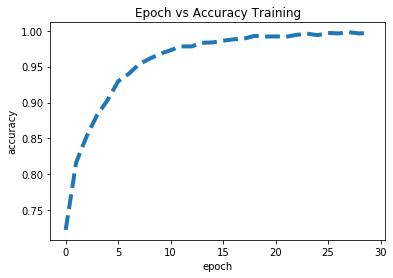

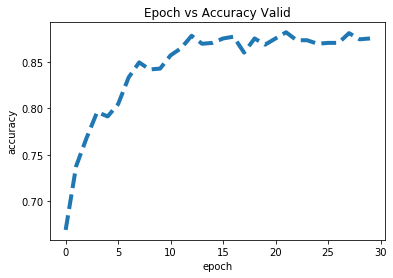

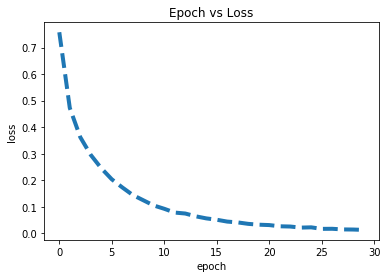

In [10]:
the_loss = history_callback.history['loss']
train_acc = history_callback.history['categorical_accuracy']
valid_acc = history_callback.history['val_categorical_accuracy']
steps = []

for i in range(30):
    steps.append(i)

plt.figure()
# plot epoch vs accuracy
plt.plot(steps,train_acc,'--',lw=4)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Epoch vs Training Accuracy')

plt.figure()
# plot epoch vs accuracy
plt.plot(steps,valid_acc,'--',lw=4)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Epoch vs Testing Accuracy')

plt.figure()
# plot epoch vs accuracy
plt.plot(steps,the_loss,'--',lw=4)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Epoch vs Loss')

In [11]:
acc = 0

#test_set_data = np.asarray(test_set_data)
#test_set_labels = np.asarray(test_set_labels)

#fetch batch
#batch_x = test_set_data[k]
#batch_y = test_set_labels[k]
#run optimization
prediction = model.predict(valid_set_data, verbose=0)
#print(prediction)
for k in range(len(valid_set_data)):
    if (np.argmax(prediction[k]) == np.argmax(valid_set_labels[k])):
        acc += 1
    else:
        acc += 0
    



acc = acc/len(valid_set_data)
print("Test Accuracy= {:.3f}".format(acc))

Test Accuracy= 0.875
